In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import os
import pandas as pd
import torch
from dataset_preprocessing import TokenInfo
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import itertools
import pandas as pd
from tqdm import tqdm

## Importances

In [5]:
def get_importances():
    # print("this is wrong")
    dir = "./new_importances_data"
    imp_files = os.listdir(dir)
    imp_files = [file for file in imp_files if file.endswith(".pkl")]
    importances = {}
    for imp_file in tqdm(imp_files):
        importances.update(pd.read_pickle(f"{dir}/{imp_file}"))
    return importances

In [6]:
# imps = get_importances()

In [7]:
def get_avg_imporances(importances):
    avg_imps = [torch.zeros_like(imp) for imp in list(importances.values())[0]]
    for token, imps in tqdm(importances.items()):
        for i, layer_imps in enumerate(imps):
            avg_imps[i] += layer_imps / len(importances)
    # TODO think harder about averaging method
    return avg_imps

In [8]:
# avg_importances = get_avg_imporances(imps)

In [9]:
# pd.to_pickle(avg_importances, "./avg_importances.pkl")

In [10]:
!ls ../

baseline_dataset.pkl  cs229-project  pcs224n  tmp-cs229-project
cs229		      LLM-Pruner     tmp


In [11]:
avg_importances = pd.read_pickle("./avg_importances.pkl")

In [12]:
len(avg_importances)

24

## Model

In [13]:
model_id = "microsoft/phi-1_5"
model_revision = "349cf8b5e81fd5f791d1740da5de1313a0419bbd" # latest as of feb 1st

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

In [15]:
vocab = tokenizer.get_vocab()
len(vocab)

50295

In [16]:
# tokenizer.decode(token_info.get_prefixes(top_tokens[1000][0], 9, 10)[0])

In [17]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    revision=model_revision,
    trust_remote_code=True,
    # be careful with this?
    # torch_dtype=torch.float16,
    # attn_implementation="flash_attention_2",
)

## Prune Model

In [18]:
from prunners import prune_mlps_individually
from importances import get_mlps

In [19]:
mlps = get_mlps(model)

In [20]:
len(mlps), len(avg_importances)

(24, 24)

In [21]:
avg_importances = dict(zip(mlps, avg_importances))

In [22]:
prune_mlps_individually(avg_importances, 0.5)

In [23]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2048, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2048,), e

## New Dataset

In [24]:
from other_datasets import get_minipile, get_c4, get_wikitext2_filtered, get_bookcorpus, get_alpaca, QADataCollator, to_dataset
from dataset import get_baseline_dataset

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [25]:
alpaca_train, alpaca_eval = get_alpaca(tokenizer, do_split=True)
# eval datasets
# tiny_text = get_baseline_dataset()["test"]
# c4 = get_c4(n=2000, do_split=False)
# minipile = get_minipile(n=2000, do_split=False)
wikitext = get_wikitext2_filtered(n=2000, do_split=False)
# bookcorpus = get_bookcorpus(n=2000, do_split=False)

2024-03-06 21:02:44.248 | INFO     | other_datasets:__init__:309 - Mean length of tokens per window: 111.64232
2024-03-06 21:02:46.031 | INFO     | other_datasets:__init__:309 - Mean length of tokens per window: 109.2675


## Metric Callback

In [26]:
from transformers import TrainerCallback

In [27]:
from evaluation import evaluate_on_nlp_tasks

In [28]:
class AccEvalCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.last_step=-1
    
    def on_evaluate(self, args, state, control, model, **kwargs):
        if state.global_step == self.last_step:
            return
        self.last_step = state.global_step
        train = model.training
        model.eval()
        with torch.no_grad():
            os.environ["TQDM_DISABLE"] = "1"
            eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=100)["results"]
            # import pdb; pdb.set_trace()
            eval_res = {k:v["acc,none"] for k,v in eval_res.items()}
            for k, v in eval_res.items():
                state.log_history.append(
                    {
                        k:v,
                        "epoch":state.epoch,
                        "step":state.global_step,
                    }
                )
            del os.environ['TQDM_DISABLE']
            print(eval_res)
        model.train(train)

In [29]:
class EnableMLPBias(TrainerCallback):
    def on_init_end(self, args, state, control, model, **kwargs):
        for n, p in model.named_parameters():
            if "base_layer" in n and "bias" in n:
                p.requires_grad = True

## Replace model modules

In [30]:
from experts import Experts, EmbeddingTokenIdxTracker, mark_only_adapters_as_trainable, prepare_as_if_peft_model, prepare_model_for_gradient_checkpointing
from importances import get_mlps
from post_training import get_lora_config, get_training_arguments

In [31]:
lora_config = get_lora_config(r=64)
training_arguments = get_training_arguments("./tmp")

In [32]:
training_arguments = prepare_as_if_peft_model(model, training_arguments, lora_config)

In [33]:
embed_tokens_new = EmbeddingTokenIdxTracker(model.get_submodule("model").get_submodule("embed_tokens"))

In [34]:
def get_layers(model):
    return model.get_submodule("model").get_submodule("layers")

In [35]:
layers = get_layers(model)

In [36]:
model.get_submodule("model").embed_tokens = embed_tokens_new

In [37]:
for i, layer in enumerate(layers):
    layer.mlp = Experts(
        model,
        layer.mlp,
        lora_config,
        i,
        embed_tokens_new.idx_tracker,
        layer.mlp.config,
        use_improved_lora=True,
    )

In [38]:
mark_only_adapters_as_trainable(model, lora_config)

In [39]:
prepare_model_for_gradient_checkpointing(model);

In [40]:
examples = ["hi this is an example", "hi this is an example"]

In [41]:
examples = torch.tensor(tokenizer.encode(examples)).view(-1, 5)

In [42]:
# model.load_state_dict(torch.load("./tmp/alpaca_model_0.5ratio_64lora_betterexpert_state_dict"))

<All keys matched successfully>

In [43]:
model.cuda();

In [43]:
# _ = model(examples.cuda())

## Train Model

In [44]:
from post_training import get_lora_config, get_training_arguments
from dataset import get_baseline_dataset
from trl import SFTTrainer
from peft import LoraConfig
import transformers
from trl import SFTTrainer
from other_datasets import SFTTrainer_

In [45]:
# Setup model for training
model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

In [46]:
# train_data, eval_data = minipile["train"], minipile["test"]
train_data, eval_data = alpaca_train, alpaca_eval
eval_datasets = {
    "alpaca":alpaca_eval,
    # "minipile":minipile,
    # "c4":c4,
    "wikitext":wikitext,
    # "tiny_text":tiny_text,
    # "bookcorpus":bookcorpus,
}

In [47]:
callbacks = [AccEvalCallback(), EnableMLPBias()]

In [48]:
# Setup tokenizer for trainign
tokenizer.pad_token = tokenizer.eos_token

In [49]:
training_arguments.save_strategy="no"

In [50]:
training_arguments.eval_steps = 100

In [51]:
trainer = SFTTrainer_(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_datasets,
    # peft_config=lora_config,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    dataset_text_field="text",
    max_seq_length=1024, # tweak this
    # TODO: think harder about the datacollator
    # data_collator=transformers.DataCollatorForSeq2Seq(
    #     tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
    # ),
    callbacks=callbacks,
    data_collator=QADataCollator(tokenizer),
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

2024-03-06:01:32:42,698 WARNING  [logging.py:61] Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [52]:
# trainer.evaluate(eval_datasets["alpaca"])

In [53]:
trainer.train()

Step,Training Loss,Validation Loss,Alpaca Loss,Wikitext Loss
100,3.287400,No log,3.099659,8.216233
200,2.230600,No log,2.218705,8.386989
300,2.033700,No log,2.085249,8.556875
400,1.976200,No log,2.018697,8.632697
500,1.991100,No log,1.980897,8.603126
600,1.935900,No log,1.955870,8.596320
700,1.950000,No log,1.935153,8.649686
800,1.874400,No log,1.920208,8.658442
900,1.880800,No log,1.906779,8.685673
1000,1.855700,No log,1.899271,8.658400


2024-03-06:02:28:56,339 WARNING  [huggingface.py:105] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-03-06:02:28:56,445 WARNING  [huggingface.py:315] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [14:36<00:00,  1.14it/s


{'hellaswag': 0.35, 'piqa': 0.61, 'boolq': 0.69, 'winogrande': 0.48}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
You're using a CodeGenTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [07:11<00:00,  2.32it/s

{'hellaswag': 0.35, 'piqa': 0.6, 'boolq': 0.69, 'winogrande': 0.55}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [07:11<00:00,  2.32it/s

{'hellaswag': 0.34, 'piqa': 0.6, 'boolq': 0.7, 'winogrande': 0.5}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [07:12<00:00,  2.31it/s

{'hellaswag': 0.36, 'piqa': 0.6, 'boolq': 0.66, 'winogrande': 0.57}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [07:12<00:00,  2.31it/s

{'hellaswag': 0.37, 'piqa': 0.59, 'boolq': 0.66, 'winogrande': 0.54}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [07:12<00:00,  2.31it/s

{'hellaswag': 0.36, 'piqa': 0.6, 'boolq': 0.57, 'winogrande': 0.54}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [07:10<00:00,  2.32it/s
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


{'hellaswag': 0.37, 'piqa': 0.6, 'boolq': 0.58, 'winogrande': 0.56}


/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [07:11<00:00,  2.32it/s

{'hellaswag': 0.37, 'piqa': 0.59, 'boolq': 0.58, 'winogrande': 0.56}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [07:11<00:00,  2.32it/s

{'hellaswag': 0.37, 'piqa': 0.59, 'boolq': 0.6, 'winogrande': 0.55}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [07:12<00:00,  2.31it/s

{'hellaswag': 0.37, 'piqa': 0.58, 'boolq': 0.6, 'winogrande': 0.55}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [07:12<00:00,  2.31it/s

{'hellaswag': 0.37, 'piqa': 0.57, 'boolq': 0.58, 'winogrande': 0.54}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [07:11<00:00,  2.32it/s

{'hellaswag': 0.37, 'piqa': 0.58, 'boolq': 0.55, 'winogrande': 0.53}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [07:12<00:00,  2.31it/s

{'hellaswag': 0.37, 'piqa': 0.6, 'boolq': 0.53, 'winogrande': 0.52}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████| 1000/1000 [14:24<00:00,  1.16it/s]


{'hellaswag': 0.37, 'piqa': 0.59, 'boolq': 0.56, 'winogrande': 0.55}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [14:37<00:00,  1.14i


{'hellaswag': 0.37, 'piqa': 0.58, 'boolq': 0.53, 'winogrande': 0.55}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


KeyboardInterrupt: 

In [54]:
trainer_state = trainer.state
pd.DataFrame(trainer_state.log_history).tail()

,loss,learning_rate,epoch,step,eval_alpaca_loss,eval_alpaca_runtime,eval_alpaca_samples_per_second,eval_alpaca_steps_per_second,hellaswag,piqa,boolq,winogrande,eval_wikitext_loss,eval_wikitext_runtime,eval_wikitext_samples_per_second,eval_wikitext_steps_per_second
235,NaN,NaN,1.800000,1500,1.861298,256.9102,7.785,0.973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,NaN,NaN,1.799856,1500,NaN,NaN,NaN,NaN,0.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,NaN,NaN,1.799856,1500,NaN,NaN,NaN,NaN,NaN,0.58,NaN,NaN,NaN,NaN,NaN,NaN
238,NaN,NaN,1.799856,1500,NaN,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN
239,NaN,NaN,1.799856,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.55,NaN,NaN,NaN,NaN


In [55]:
pd.to_pickle(trainer.state, "./tmp/alpaca_trainer_state_0.5ratio_64lora_betterexpert.pkl")

### Evaluation

In [85]:
from evaluation import evaluate_on_nlp_tasks

In [86]:
model.cuda();

In [87]:
model.eval();

In [88]:
with torch.no_grad():
    eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=300)

2024-03-06:21:09:20,321 WARNING  [huggingface.py:105] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-03-06:21:09:20,375 WARNING  [huggingface.py:315] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|████████████████████████████████████████████| 30

In [89]:
eval_res["results"]

{'hellaswag': {'acc,none': 0.32,
  'acc_norm,none': 0.35333333333333333,
  'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.58, 'acc_norm,none': 0.6, 'alias': 'piqa'},
 'boolq': {'acc,none': 0.5133333333333333, 'alias': 'boolq'},
 'winogrande': {'acc,none': 0.5166666666666667, 'alias': 'winogrande'}}

In [ ]:
eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=1000)

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
 15%|██████▎                                  | 1538/10000 [21:12<1:54:08,  1.24it/s]

In [ ]:
eval_res["results"]

## Save

In [59]:
model.cpu();

In [60]:
torch.save(model.state_dict(), "./tmp/alpaca_model_0.5ratio_64lora_betterexpert_state_dict")

## Looking at stats

In [61]:
df = pd.DataFrame(trainer_state.log_history)

In [62]:
metrics_df = df[["step", "hellaswag", "piqa", "boolq", "winogrande"]]

<Axes: xlabel='step'>

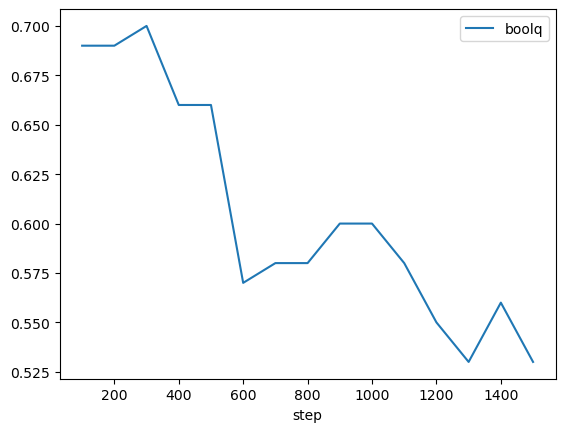

In [63]:
metrics_df[["step", "boolq"]].dropna().set_index("step").plot()

<Axes: xlabel='step'>

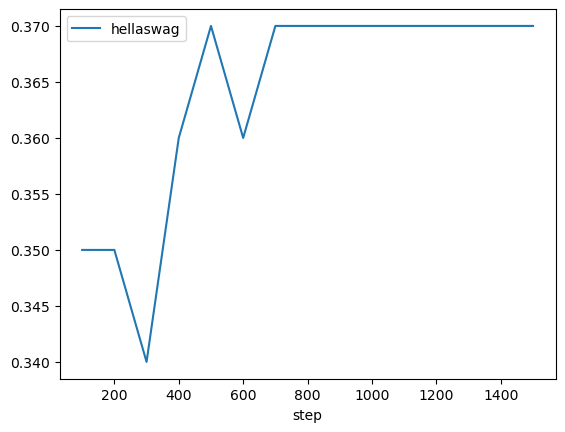

In [64]:
metrics_df[["step", "hellaswag"]].dropna().set_index("step").plot()

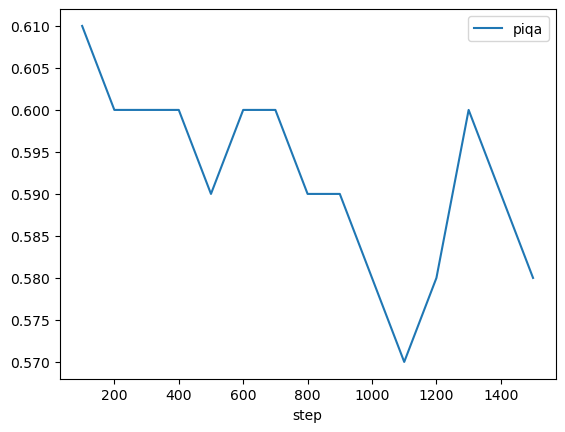

In [65]:
metrics_df = df[["step", "piqa"]].dropna().set_index("step").plot()

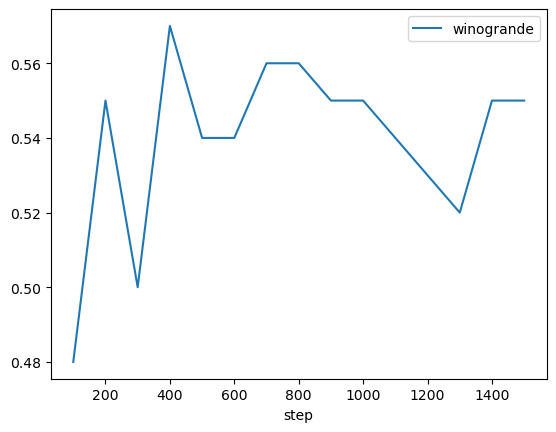

In [66]:
metrics_df = df[["step", "winogrande"]].dropna().set_index("step").plot()

In [67]:
eval_df = df[["step", "eval_alpaca_loss", "eval_wikitext_loss"]].set_index("step")

<Axes: xlabel='step'>

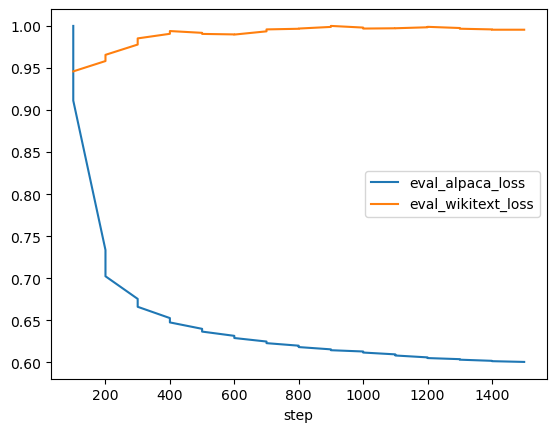

In [68]:
(eval_df / eval_df.max()).interpolate(method='linear').plot()

<Axes: xlabel='step'>

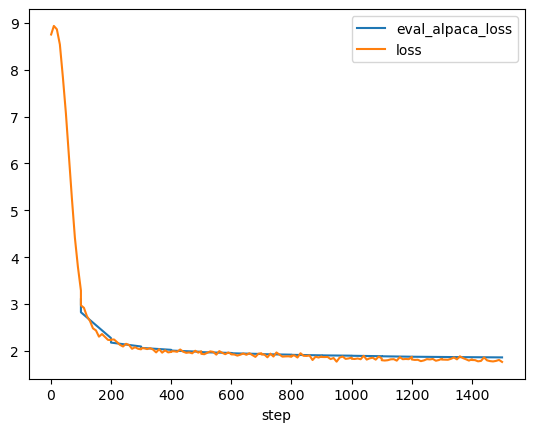

In [69]:
df[["step", "eval_alpaca_loss", "loss"]].set_index("step").interpolate(method='linear').plot()